In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from copy import deepcopy
import time
import random
from scipy import stats
from scipy.stats import mode
import seaborn as sns
import warnings
from collections import defaultdict
warnings.filterwarnings("ignore")
from scipy.stats import chisquare

## Hits where antibiotic resistance evolves first
#### Exclude hits with two non-related antibiotics -> these go in co-linearity section

In [2]:
# Merge sequential and simultaneous hits into a single table

all_hits_sequential = pd.read_csv("output/04A.pair_annotation/results_allpairs_annotation_withcategories.csv", index_col=0)
all_simultaneous = pd.read_csv("output/04B.pair_annotation/results_allpairs_annotation_withcategories.csv", index_col=0)

sequential_merged = all_hits_sequential.merge(all_simultaneous[["position_i", "position_j", "pval_beta_i_on_j", 'pval_beta_i_on_j_BH_sig']], 
                                                on=["position_i", "position_j"], how="left", suffixes=["_sequential", "_simultaneous"])

simultaneous_merged = all_simultaneous.merge(all_hits_sequential[["position_i", "position_j", "pval_beta_i_on_j", 'pval_beta_i_on_j_BH_sig']], 
                                                on=["position_i", "position_j"], how="left", suffixes=[ "_simultaneous", "_sequential"])

all_hits = pd.concat([simultaneous_merged, sequential_merged])
all_hits = all_hits.drop_duplicates(subset=["position_i", "position_j"]).reset_index(drop=True)


In [3]:
display_positions =['position_i', 'gene_name_i', 'position_j', 'gene_name_j',
       'n_mutations_i', 'n_mutations_j', 'n_branches_with_i',
    'n_muts_i_on_branch_j', 'n_muts_same_branch','pval_beta_i_on_j',
       'pval_beta_i_on_j_BH_sig']

In [4]:
known_antibiotic_first = all_hits.dropna(subset=["known_drug_j"]).query("pval_beta_i_on_j_BH_sig_sequential or pval_beta_i_on_j_BH_sig_simultaneous")

known_antibiotic_first['num_dependent'] = known_antibiotic_first.n_muts_i_on_branch_j + known_antibiotic_first.n_muts_same_branch
know_ab_first = known_antibiotic_first.loc[known_antibiotic_first.possible_drug_i.isnull(), :]
know_ab_first.sort_values('num_dependent', ascending=False).head(40)
print(len(know_ab_first))

1879


In [6]:
def _process_known_hits(input_list):
    """
    splits the possible associated drugs (string separated by ,) into a list
    """
    output_list = []
    for item in input_list:
        #print(item)
        if type(item) != str:
            output_list.append(np.nan)
        else:
            splitted = item.split(",")
            exclusive= list(set(splitted))
            output_list.append(exclusive)
    return output_list

known_antibiotic_first = all_hits.dropna(subset=["known_drug_j"]).query("pval_beta_i_on_j_BH_sig_sequential or pval_beta_i_on_j_BH_sig_simultaneous")

known_antibiotic_first["known_drug_i"] = _process_known_hits(known_antibiotic_first.known_drug_i)
known_antibiotic_first["possible_drug_i"] = _process_known_hits(known_antibiotic_first.possible_drug_i)

known_antibiotic_first["known_drug_j"] = _process_known_hits(known_antibiotic_first.known_drug_j)
known_antibiotic_first["possible_drug_j"] = _process_known_hits(known_antibiotic_first.possible_drug_j)

print(len(known_antibiotic_first))

3724


In [5]:
between_antibiotic_indices = []
antibiotic_indices = []

known_antibiotic_first["within_same_drug"] = False

for idx, row in known_antibiotic_first.iterrows():
    
    set_of_known_first = set(row.known_drug_j)
    set_of_known_second = set()
    known_drug_second = False
    
    if type(row.known_drug_i) is list:
        set_of_known_second= set(row.known_drug_i)
        known_drug_second = True
        
    elif type(row.possible_drug_i) is list:
        set_of_known_second= set(row.possible_drug_i)
        known_drug_second = True
        
    if not known_drug_second:
        antibiotic_indices.append(idx)
    
    elif len(set_of_known_first.intersection(set_of_known_second)) > 0:
        antibiotic_indices.append(idx)
        known_antibiotic_first.loc[idx, "within_same_drug"] = True
        
    else:
        between_antibiotic_indices.append(idx)
        
between_antibiotic_hits = known_antibiotic_first.loc[between_antibiotic_indices]
antibiotic_hits = known_antibiotic_first.loc[antibiotic_indices]
    

In [6]:
!mkdir output/05.antibiotic
print(len(antibiotic_hits))
antibiotic_hits.to_csv("output/05.antibiotic/antibiotic_hits.csv")
between_antibiotic_hits.to_csv("output/05.antibiotic/between_antibiotic_hits.csv")
all_hits.to_csv("output/05.antibiotic/all_pairs.csv")

mkdir: cannot create directory ‘output/05.antibiotic’: File exists
3724


## Compute per-drug output tables

In [9]:
## These will contain all hits except the between-antibiotic hits

## First get the list of all names of drugs in the dataset
drug_list = []
for idx, row in antibiotic_hits.iterrows():
    drugs1 = row.possible_drug_j
    drugs2 = row.possible_drug_i
    
    if type(drugs1) != list:
        drugs1= []
    if type(drugs2) != list:
        drugs2=[]
    
    for drug in drugs1 + drugs2:
        drug_list.append(drug)

drug_list = list(set(drug_list))

## Then create an empty df for each
df_dict = {drug:pd.DataFrame() for drug in drug_list}

## now concatenate each row to the appropriate drug dataframe
for idx, row in antibiotic_hits.iterrows():
    drugs1 = row.possible_drug_j
    drugs2 = row.possible_drug_i
    
    if type(drugs1) != list:
        drugs1= []
    if type(drugs2) != list:
        drugs2=[]
    
    for drug in drugs1:
        df_dict[drug] = df_dict[drug].append(row)
        
    for drug in drugs2:
        df_dict[drug] = df_dict[drug].append(row)
        
for drug, df in df_dict.items():
    print(drug, len(df))
    df.sort_values("n_muts_i_on_branch_j", ascending=False).to_csv(f"output/05.antibiotic/{drug}_antibiotic_hits.csv")
    df.query("pval_beta_i_on_j_BH_sig_sequential != 0").query("pval_beta_i_on_j_BH_sig_sequential").sort_values(
        "n_muts_i_on_branch_j", ascending=False
    ).to_csv(f"output/05.antibiotic/{drug}_antibiotic_hits_sequential.csv")

RIF 524
ETH 85
LEV 13
MXF 13
PZA 130
CAP 113
INH 410
KAN 175
STM 422
LZD 108
EMB 387
AMI 176


In [10]:
## These will contain all hits except the between-antibiotic hits

## First get the list of all names of drugs in the dataset
drug_list = []
for idx, row in between_antibiotic_hits.iterrows():
    drugs1 = row.possible_drug_j
    drugs2 = row.possible_drug_i
    
    if type(drugs1) != list:
        drugs1= []
    if type(drugs2) != list:
        drugs2=[]
    
    for drug in drugs1 + drugs2:
        drug_list.append(drug)

drug_list = list(set(drug_list))

## Then create an empty df for each
df_dict = {drug:pd.DataFrame() for drug in drug_list}

## now concatenate each row to the appropriate drug dataframe
for idx, row in between_antibiotic_hits.iterrows():
    drugs1 = row.possible_drug_j
    drugs2 = row.possible_drug_i
    
    if type(drugs1) != list:
        drugs1= []
    if type(drugs2) != list:
        drugs2=[]
    
    for drug in drugs1:
        df_dict[drug] = df_dict[drug].append(row)
        
    for drug in drugs2:
        df_dict[drug] = df_dict[drug].append(row)
        
for drug, df in df_dict.items():
    print(drug, len(df))
    df.sort_values("n_muts_i_on_branch_j", ascending=False).to_csv(f"output/05.antibiotic/{drug}_between_antibiotic_hits.csv")

RIF 739
ETH 176
LEV 238
DLM 1
MXF 238
CAP 211
PZA 663
CFZ 6
INH 390
KAN 321
STM 501
LZD 204
BDQ 6
EMB 570
AMI 323


\## Fraction of resistant strains with a dependent mutation

In [11]:
# Here let strains with a resistance-conferring mutation be defined as resistant
# Then count the number of resistant strains that have another mutation

snps = pd.read_csv("output/03.annotation/snps_with_all_annotation.csv", index_col=0)
snps = snps.query("not is_lineage")

# list of resistance mutations
resistance_mutations = snps.query("in_known_ABR_position")
resistance_mutations["known_drug"] = _process_known_hits(resistance_mutations.known_drug)

antibiotic_hits = antibiotic_hits.query("pval_beta_i_on_j_BH_sig_sequential")
print(len(antibiotic_hits))
# list of all other mutations
other_positions = list(set(antibiotic_hits.position_i))
other_mutations = snps.query("pos in @other_positions")



1446


In [12]:
!mkdir output/05.antibiotic

mkdir: cannot create directory ‘output/05.antibiotic’: File exists


In [13]:
# # Read in the matrix of isolate x genotype
# # Input information from Roger
genotype_translator = {
0:"A", 1:"C", 2:"G", 3:"T", 9:"N"
}
isolate_annotation_file = "/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_isolate_annotation.pkl"
genotype_array_file = "/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_matrix.npy"
snp_annotation_file = "/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_annotation.pkl"
genotype_translator_r = {y:x for x,y in genotype_translator.items()}

isolates = pd.read_pickle(isolate_annotation_file)
genotypes = np.load(genotype_array_file)
snps_older = pd.read_pickle(snp_annotation_file)
# # Filter out the snps we don't need
snps_to_retain = snps_older.query("pos in @other_positions or pos in @resistance_mutations.pos")
indices_to_keep = snps_to_retain.index

g = genotypes[indices_to_keep, :]
del genotypes
np.save("output/05.antibiotic/antibiotic_genotypes_matrix.npy", g)
g = np.load("output/05.antibiotic/antibiotic_genotypes_matrix.npy")

In [14]:
snps_to_retain = snps_to_retain.reset_index()

In [15]:
!mkdir output/05.antibiotic/strains_with_dependencies_per_AB/

mkdir: cannot create directory ‘output/05.antibiotic/strains_with_dependencies_per_AB/’: File exists


In [16]:
# For each drug, get the set of mutations we are looking for
drug_to_sensitive_sites = {drug:[] for drug in drug_list}
for idx, row in resistance_mutations.iterrows():
    for drug in row.known_drug:
        drug_to_sensitive_sites[drug].append((row.pos, row.ref))

# Find strains that have any of those mutations
drug_to_indices_R_strains = {}

_num_sequential_dependencies = []
for drug, list_of_tuples in drug_to_sensitive_sites.items():
    
    has_sensitive_alleles = np.ones(shape=(len(list_of_tuples), g.shape[1]))
    #print(drug)
    
    for idx, (pos, nt) in enumerate(list_of_tuples):
    
        matrix_index = snps_to_retain.query("pos==@pos").index
        has_sensitive_alleles[idx,:] = g[matrix_index, :] == genotype_translator_r[nt]
        
    #print(np.sum(np.sum(has_sensitive_alleles, axis=0) < has_sensitive_alleles.shape[0]))
    indices_R_strains = np.where(np.sum(has_sensitive_alleles, axis=0) < has_sensitive_alleles.shape[0])[0]
    drug_to_indices_R_strains[drug] = indices_R_strains
    
    try:
        drug_specific_dependencies = pd.read_csv(f"output/05.antibiotic/{drug}_antibiotic_hits.csv", index_col=0)
    except:
        print("no file for", drug)
        continue
    drug_specific_dependencies = drug_specific_dependencies.query(
        "pval_beta_i_on_j_BH_sig_sequential")
    
    # Get the dependent positions - exclude any known resistance mutation from dependent sites
    dependent_positions = set(drug_specific_dependencies.position_i) - set(resistance_mutations.pos)
    dependencies = snps_to_retain.query("pos in @dependent_positions")
    #print(drug, "has", len(dependencies), "dependencies excluding known R positions")
    assert(len(dependent_positions) == len(dependencies))
    
    # Create a matrix of which strains have a dependent mutation
    _dependency_df = []
    has_dependent_alleles = np.ones(shape=(len(dependencies), len(indices_R_strains)))
    for mat_idx, (idx, row) in enumerate(dependencies.iterrows()):
        has_dependency = g[:, indices_R_strains][idx, :] != genotype_translator_r[row.ref]
        total_has_dependency = g[idx, :] != genotype_translator_r[row.ref]
        _dependency_df.append([idx, row.pos, row.ref, np.sum(has_dependency), np.sum(total_has_dependency)])
        has_dependent_alleles[mat_idx, :] = has_dependency
    
    dependency_df = pd.DataFrame(_dependency_df, columns=["matrix_idx", "pos", "ref", "num_R_strains_with_dependency", "total_strains_with_mutation"])
    dependency_df.to_csv(f"output/05.antibiotic/strains_with_dependencies_per_AB/{drug}.csv")
    
    _num_sequential_dependencies.append([drug, len(indices_R_strains), np.sum(np.sum(has_dependent_alleles, axis=0) > 0)])

df = pd.DataFrame(_num_sequential_dependencies, columns=["drug", "num_R_strains", "num_R_strains_with_dependency"])
df["fraction"] = df.num_R_strains_with_dependency / df.num_R_strains
df.to_csv("output/05.antibiotic/num_strains_with_dependency.csv")    
df

no file for DLM
no file for CFZ
no file for BDQ


,drug,num_R_strains,num_R_strains_with_dependency,fraction
0,RIF,10083,8930,0.885649
1,ETH,5744,2256,0.392758
2,LEV,3153,198,0.062797
3,MXF,3153,198,0.062797
4,CAP,3194,1493,0.467439
5,PZA,9563,9467,0.989961
6,INH,11143,8957,0.803823
7,KAN,4410,2490,0.564626
8,STM,10967,9078,0.827756
9,LZD,109,54,0.495413


In [17]:
# Here let strains with a resistance-conferring mutation be defined as resistant
# Then count the number of resistant strains that have another mutation
#include simultaenous and sequential

snps = pd.read_csv("output/03.annotation/snps_with_all_annotation.csv", index_col=0)
snps = snps.query("not is_lineage")

# list of resistance mutations
resistance_mutations = snps.query("in_known_ABR_position")
resistance_mutations["known_drug"] = _process_known_hits(resistance_mutations.known_drug)
antibiotic_hits = pd.read_csv("output/05.antibiotic/antibiotic_hits.csv")
print(len(antibiotic_hits))
# list of all other mutations
antibiotic_hits["dist"] = np.abs(antibiotic_hits.position_j - antibiotic_hits.position_i)
antibiotic_hits = antibiotic_hits.query("pval_beta_i_on_j_BH_sig_sequential or (pval_beta_i_on_j_BH_sig_simultaneous and dist >100)")
print(len(antibiotic_hits))


1987
1973


In [18]:

other_positions = list(set(antibiotic_hits.position_i))
other_mutations = snps.query("pos in @other_positions")

# # Read in the matrix of isolate x genotype
# # Input information from Roger
genotype_translator = {
0:"A", 1:"C", 2:"G", 3:"T", 9:"N"
}
isolate_annotation_file = "/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_isolate_annotation.pkl"
genotype_array_file = "/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_matrix.npy"
snp_annotation_file = "/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_annotation.pkl"
genotype_translator_r = {y:x for x,y in genotype_translator.items()}

isolates = pd.read_pickle(isolate_annotation_file)
genotypes = np.load(genotype_array_file)
snps_older = pd.read_pickle(snp_annotation_file)
# # Filter out the snps we don't need
snps_to_retain = snps_older.query("pos in @other_positions or pos in @resistance_mutations.pos")
indices_to_keep = snps_to_retain.index

g = genotypes[indices_to_keep, :]
del genotypes
np.save("output/05.antibiotic/antibiotic_genotypes_matrix.npy", g)
g = np.load("output/05.antibiotic/antibiotic_genotypes_matrix.npy")

snps_to_retain = snps_to_retain.reset_index()

In [19]:
# For each drug, get the set of mutations we are looking for
drug_to_sensitive_sites = {drug:[] for drug in drug_list}
for idx, row in resistance_mutations.iterrows():
    for drug in row.known_drug:
        drug_to_sensitive_sites[drug].append((row.pos, row.ref))

# Find strains that have any of those mutations
drug_to_indices_R_strains = {}

_num_sequential_dependencies = []
for drug, list_of_tuples in drug_to_sensitive_sites.items():
    
    has_sensitive_alleles = np.ones(shape=(len(list_of_tuples), g.shape[1]))
    #print(drug)
    
    # Determine if each isolate has any sensitive allele
    for idx, (pos, nt) in enumerate(list_of_tuples):
    
        matrix_index = snps_to_retain.query("pos==@pos").index
        has_sensitive_alleles[idx,:] = g[matrix_index, :] == genotype_translator_r[nt]
        
    #print(np.sum(np.sum(has_sensitive_alleles, axis=0) < has_sensitive_alleles.shape[0]))
    indices_R_strains = np.where(np.sum(has_sensitive_alleles, axis=0) < has_sensitive_alleles.shape[0])[0]
    drug_to_indices_R_strains[drug] = indices_R_strains
    
    try:
        drug_specific_dependencies = pd.read_csv(f"output/05.antibiotic/{drug}_antibiotic_hits.csv", index_col=0)
    except:
        print("no file for", drug)
        continue
    #drug_specific_dependencies = drug_specific_dependencies.query("pval_beta_i_on_j_BH_sig_sequential == 'True'")
    
    # Get the dependent positions - exclude any known resistance mutation from dependent sites
    dependent_positions = set(drug_specific_dependencies.position_i) - set(resistance_mutations.pos)
    dependencies = snps_to_retain.query("pos in @dependent_positions")
    print(drug, "has", len(dependencies), "dependencies excluding known R positions")
    #assert(len(dependent_positions) == len(dependencies))
    
    # Create a matrix of which strains have a dependent mutation
    _dependency_df = []
    has_dependent_alleles = np.ones(shape=(len(dependencies), len(indices_R_strains)))
    for mat_idx, (idx, row) in enumerate(dependencies.iterrows()):
        has_dependency = g[:, indices_R_strains][idx, :] != genotype_translator_r[row.ref]
        total_has_dependency = g[idx, :] != genotype_translator_r[row.ref]
        _dependency_df.append([idx, row.pos, row.ref, np.sum(has_dependency), np.sum(total_has_dependency)])
        has_dependent_alleles[mat_idx, :] = has_dependency
    
    dependency_df = pd.DataFrame(_dependency_df, columns=["matrix_idx", "pos", "ref", "num_R_strains_with_dependency", "total_strains_with_mutation"])
    dependency_df.to_csv(f"output/05.antibiotic/strains_with_dependencies_per_AB/{drug}.csv")
    
    _num_sequential_dependencies.append([drug, len(indices_R_strains), np.sum(np.sum(has_dependent_alleles, axis=0) > 0)])
    
df = pd.DataFrame(_num_sequential_dependencies, columns=["drug", "num_R_strains", "num_R_strains_with_dependency"])
df["fraction"] = df.num_R_strains_with_dependency / df.num_R_strains
df.to_csv("output/05.antibiotic/num_strains_with_dependency_simultaneous.csv")    


RIF has 404 dependencies excluding known R positions
ETH has 81 dependencies excluding known R positions
LEV has 6 dependencies excluding known R positions
no file for DLM
MXF has 6 dependencies excluding known R positions
CAP has 98 dependencies excluding known R positions
PZA has 121 dependencies excluding known R positions
no file for CFZ
INH has 396 dependencies excluding known R positions
KAN has 129 dependencies excluding known R positions
STM has 375 dependencies excluding known R positions
LZD has 93 dependencies excluding known R positions
no file for BDQ
EMB has 309 dependencies excluding known R positions
AMI has 130 dependencies excluding known R positions


In [20]:
len(dependent_positions)

130

In [21]:
len(other_positions)

696

### Plot fraction of resistant strains with a dependent mutation

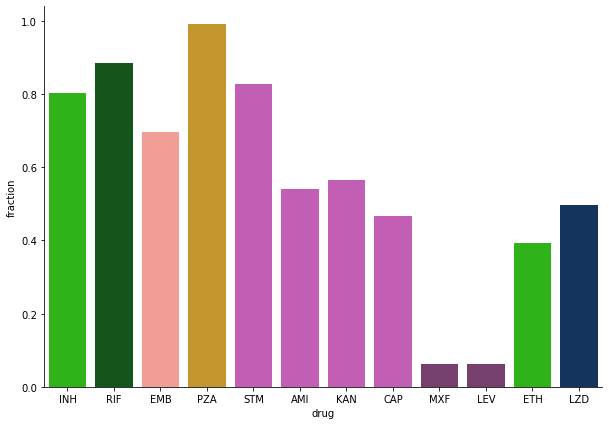

In [21]:
list_of_colors = [
    (30, 204, 0),
    (9, 96, 19),
    (255, 146, 135),
    (221, 160, 21),
    (210,78,193),
    (210,78,193),
    (210,78,193),
    
    (210,78,193),
    
    (128,54,115),
    (128,54,115),
    (30,204,0),
    (9, 50, 105),
    
    (128,54,115),
    (128,54,115),
    (128,54,115),
    (128,54,115),
    (139,192,221),
    (9, 50, 105),

    (189,189,189)
]
list_of_colors = [(x/255,y/255, z/255) for x,y,z in list_of_colors]

# Make plot

df_both = pd.read_csv("output/05.antibiotic/num_strains_with_dependency_simultaneous.csv", index_col=0) 
df_single = pd.read_csv("output/05.antibiotic/num_strains_with_dependency.csv", index_col=0)  

df_both["label"]= "both"
df_single["label"] = "sequential_only"

sorted_drug_list = [ 'INH', "RIF", "EMB", "PZA", 
                     'STM', 'AMI','KAN', 'CAP',
                     'MXF', 'LEV', 'ETH',
                    'DLM','CFZ','LZD','BDQ'
]

#df = pd.concat([df_both, df_single])
df = df_single
# Generate a rank column that will be used to sort
# the dataframe numerically
sorterIndex = dict(zip(sorted_drug_list, range(len(sorted_drug_list))))
df['ab_rank'] = df['drug'].map(sorterIndex)
df = df.sort_values("ab_rank")
sns.set_palette(sns.color_palette(list_of_colors))
figure=plt.figure(figsize=(10,7))
sns.barplot(data=df,x="drug", y="fraction", palette= sns.color_palette(list_of_colors))
sns.despine()
plt.savefig("figures/percent_strains_with_dependency.pdf")

## Presence of Featured mutations in the paper

In [29]:
antibiotic_hits = pd.read_csv("output/05.antibiotic/antibiotic_hits.csv")
display_positions =['position_i', 'gene_name_i', 'position_j', 'gene_name_j',
                    
       'n_mutations_i', 'n_mutations_j', 'n_branches_with_i',
    'n_muts_i_on_branch_j', 'n_muts_same_branch',
       'pval_beta_i_on_j_BH_sig_sequential', 'pval_beta_i_on_j_BH_sig_simultaneous']

In [30]:
antibiotic_hits.sort_values("n_muts_i_on_branch_j", ascending=False)

,Unnamed: 0.1,Unnamed: 0,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_branches_with_j,...,in_antigen_protein_j,in_known_ABR_position_j,known_drug_j,in_possible_ABR_gene_j,possible_drug_j,annotation,pval_beta_i_on_j_sequential,pval_beta_i_on_j_BH_sig_sequential,median_distance,within_same_drug
644,539315,168228,764817,rpoC,761155,rpoB,281,1687,921,9165,...,True,True,['RIF'],True,['RIF'],known_AB_first,1.948885e-70,True,32.419193,True
22,45352,211,1673425,None,2155168,katG,786,2098,3817,12564,...,True,True,['INH'],True,['INH'],between_known_AB,1.000000e+00,False,NaN,True
37,45598,475,1673432,None,2155168,katG,107,2098,523,12564,...,True,True,['INH'],True,['INH'],between_known_AB,2.550422e-13,True,NaN,True
670,539375,168292,764840,rpoC,761155,rpoB,63,1687,192,9165,...,True,True,['RIF'],True,['RIF'],known_AB_first,1.883517e-34,True,29.348090,True
1024,547017,234166,2986827,Rv2670c,2155168,katG,96,2098,671,12564,...,True,True,['INH'],True,['INH'],known_AB_first,2.627668e-09,True,57.014217,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,59373,63355,4235607,Rv3789,4247730,embB,16,337,30,839,...,False,True,['EMB'],True,['EMB'],known_AB_first,NaN,False,NaN,False
584,71196,113482,666107,pncB2,4327033,ethA,18,8,196,22,...,False,True,['ETH'],True,['ETH'],known_AB_first,NaN,False,NaN,False
436,59425,63409,4056258,espA,4247730,embB,5,337,14,839,...,False,True,['EMB'],True,['EMB'],known_AB_first,NaN,False,NaN,False
583,71195,113481,2699402,Rv2402,4327033,ethA,19,8,204,22,...,False,True,['ETH'],True,['ETH'],known_AB_first,NaN,False,NaN,False


In [31]:

antibiotic_hits.query('gene_name_i=="nusG" and gene_name_j=="rpoB"')[display_positions]

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous
124,734624,nusG,761155,rpoB,14,1687,32,6,7,False,True
131,734458,nusG,761155,rpoB,10,1687,4,6,2,True,False
138,734470,nusG,761155,rpoB,6,1687,10,3,3,False,True


In [32]:
all_hits.query('position_i==2726142 and gene_name_j=="katG"')[display_positions]

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous
548715,2726142,None,2155168,katG,39,2098,20,5,4,False,NaN


In [33]:
all_hits.query('position_j==2726142 and gene_name_i=="katG"')[display_positions]

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous
8864,2154083,katG,2726142,None,7,39,0,0,1,NaN,True
8871,2155541,katG,2726142,None,35,39,32,0,1,NaN,False
8872,2156110,katG,2726142,None,6,39,0,0,1,NaN,True
8873,2155295,katG,2726142,None,6,39,2,0,1,NaN,True
49113,2155168,katG,2726142,None,2098,39,12564,0,4,False,False
49120,2155167,katG,2726142,None,56,39,136,0,1,NaN,False


In [34]:
antibiotic_hits.query('gene_name_i=="hadA" and gene_name_j=="katG"')[display_positions]

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous
24,732110,hadA,2155168,katG,57,2098,84,19,32,False,True
33,732111,hadA,2155168,katG,16,2098,42,5,10,False,True


In [35]:
# whiB7 upstream region
all_hits.query('gene_name_i=="r_whiB7" and gene_name_j=="whiB6"')[display_positions]

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous


In [36]:

# whiB7
all_hits.query('position_i > 3568679 and position_i <3569109 and gene_name_j=="whiB6"')[display_positions]

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous
702660,3568795,None,4338371,whiB6,15,8,64,6,0,True,NaN
702686,3568759,None,4338371,whiB6,31,8,62,2,0,False,NaN
702796,3568736,None,4338371,whiB6,8,8,2,5,0,True,NaN


In [37]:

# eis upstream region
subset = all_hits.query('position_i > 2714124 and position_i<2715472 and gene_name_j=="whiB6"')
subset = subset.query("pval_beta_i_on_j_BH_sig_sequential or pval_beta_i_on_j_BH_sig_simultaneous")
print(subset.n_muts_i_on_branch_j.sum() + subset.n_muts_same_branch.sum())
subset[display_positions]

104


,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous
618518,2715342,None,4338371,whiB6,141,8,350,57,0,True,NaN
618522,2715346,None,4338371,whiB6,83,8,190,9,0,True,NaN
618524,2715344,None,4338371,whiB6,76,8,526,18,0,True,NaN
618527,2715369,None,4338371,whiB6,41,8,506,17,0,True,NaN
631887,2715342,None,4338326,whiB6,141,5,350,3,0,True,NaN


In [38]:

# eis upstream region and rrs - 38 mutations
all_hits.query('position_i > 2714124 and position_i<2715472 and position_j > 1471846 and position_j<1473382 and pval_beta_i_on_j_BH_sig_sequential ')[display_positions]
subset = all_hits.query('position_i > 2714124 and position_i<2715472 and position_j > 1471846 and position_j<1473382 and pval_beta_i_on_j_BH_sig_sequential ')
subset = subset.query("pval_beta_i_on_j_BH_sig_sequential or pval_beta_i_on_j_BH_sig_simultaneous")
print(subset.n_muts_i_on_branch_j.sum() + subset.n_muts_same_branch.sum())

46


In [39]:
# rrsto WhiB6 10 mutations
subset= all_hits.query('position_i > 1471846 and position_i<1473382  and gene_name_j=="whiB6"and pval_beta_i_on_j_BH_sig_simultaneous ')[display_positions].head(10)
subset = subset.query("pval_beta_i_on_j_BH_sig_sequential or pval_beta_i_on_j_BH_sig_simultaneous")
print(subset.n_muts_i_on_branch_j.sum() + subset.n_muts_same_branch.sum())

5


In [40]:
antibiotic_hits.query("pval_beta_i_on_j_BH_sig_sequential").sort_values("n_muts_i_on_branch_j", ascending=False)[display_positions].head(50)

,position_i,gene_name_i,position_j,gene_name_j,n_mutations_i,n_mutations_j,n_branches_with_i,n_muts_i_on_branch_j,n_muts_same_branch,pval_beta_i_on_j_BH_sig_sequential,pval_beta_i_on_j_BH_sig_simultaneous
644,764817,rpoC,761155,rpoB,281,1687,921,145,125,True,NaN
37,1673432,None,2155168,katG,107,2098,523,49,17,True,True
670,764840,rpoC,761155,rpoB,63,1687,192,44,19,True,NaN
1024,2986827,Rv2670c,2155168,katG,96,2098,671,40,35,True,NaN
972,3073679,None,2155168,katG,53,2098,192,39,6,True,NaN
690,764363,rpoC,761155,rpoB,58,1687,78,38,17,True,NaN
1002,2747471,folC,2155168,katG,74,2098,86,38,19,True,NaN
648,3073679,None,761155,rpoB,53,1687,192,36,7,True,NaN
691,764948,rpoC,761155,rpoB,51,1687,70,35,16,True,NaN
665,3877949,rpoA,761155,rpoB,55,1687,50,35,18,True,NaN


## Get the nucleotide changes for individual SNPs

In [41]:
snps = pd.read_pickle("/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_functional_annotation.pkl")
snps.query("gene_name=='katG'")

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,SNP_type,AA_change
2153889_C,2153889,T,C,Antibiotic Resistance,katG,Rv1908c,2223,N,*741W
2153891_G,2153891,A,G,Antibiotic Resistance,katG,Rv1908c,2221,N,*741R
2153897_T,2153897,C,T,Antibiotic Resistance,katG,Rv1908c,2215,N,V739M
2153905_T,2153905,C,T,Antibiotic Resistance,katG,Rv1908c,2207,N,R736K
2153908_G,2153908,T,G,Antibiotic Resistance,katG,Rv1908c,2204,N,D735A
...,...,...,...,...,...,...,...,...,...
2156104_C,2156104,T,C,Antibiotic Resistance,katG,Rv1908c,8,N,E3G
2156106_A,2156106,G,A,Antibiotic Resistance,katG,Rv1908c,6,S,P2P
2156109_A,2156109,C,A,Antibiotic Resistance,katG,Rv1908c,3,S,V1V
2156109_T,2156109,C,T,Antibiotic Resistance,katG,Rv1908c,3,S,V1V


In [42]:
snps = pd.read_pickle("/n/data1/hms/dbmi/farhat/Roger/homoplasy_project/rolling_DB_scrape/Genotypes_Filtered_2/genotypes_SNP_functional_annotation.pkl")
snps.query("gene_name=='nusG'")

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,SNP_type,AA_change
734254_A,734254,G,A,Non-Essential,nusG,Rv0639,1,N,V1M
734258_A,734258,C,A,Non-Essential,nusG,Rv0639,5,N,T2N
734261_A,734261,C,A,Non-Essential,nusG,Rv0639,8,N,T3N
734262_G,734262,C,G,Non-Essential,nusG,Rv0639,9,S,T3T
734264_C,734264,T,C,Non-Essential,nusG,Rv0639,11,N,F4S
...,...,...,...,...,...,...,...,...,...
734905_T,734905,C,T,Non-Essential,nusG,Rv0639,652,S,L218L
734948_G,734948,T,G,Non-Essential,nusG,Rv0639,695,N,F232C
734959_G,734959,T,G,Non-Essential,nusG,Rv0639,706,N,S236A
734964_A,734964,G,A,Non-Essential,nusG,Rv0639,711,S,K237K


In [43]:
snps.query("pos==734624")

,pos,ref,alt,gene_category,gene_name,gene_id,gene_pos,SNP_type,AA_change
734624_A,734624,G,A,Non-Essential,nusG,Rv0639,371,N,R124H
734624_T,734624,G,T,Non-Essential,nusG,Rv0639,371,N,R124L


## Analysis of sequentiall mutations

In [44]:
drug_list = [ 'INH',
 'RIF', 
 'EMB', 
 'PZA', 
 'STM',
 'AMI',
 'KAN',
 'CAP',
 'MXF',
 'LEV',          
 'ETH',
'LZD',
             'CFZ',
             'BDQ'
            ]

INH 125
RIF 138
EMB 104
PZA 281
STM 160
AMI 104
KAN 104
CAP 69
MXF 100
LEV 100
ETH 66
LZD 64
CFZ 0
BDQ 0


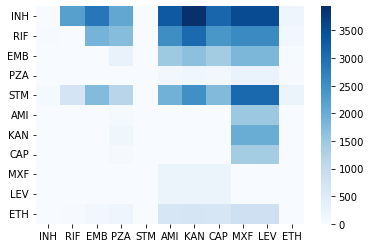

In [45]:
import ast

number_of_links = np.zeros((len(drug_list), len(drug_list)))
drug_to_idx = {drug:i for i, drug in enumerate(drug_list)}
                            
for drug in drug_list: 
    between_hits = pd.read_csv(f"output/05.antibiotic/{drug}_between_antibiotic_hits.csv", index_col=0).drop_duplicates()

    between_hits = between_hits.dropna(subset=["known_drug_i", "known_drug_j", "pval_beta_i_on_j_BH_sig_sequential"])
    between_hits = between_hits.query("pval_beta_i_on_j_BH_sig_sequential")
    print(drug, len(between_hits))
    
    for idx, row in between_hits.iterrows():
        for first_drug in ast.literal_eval(row.known_drug_j):
            for second_drug in ast.literal_eval(row.known_drug_i):
                
                number_of_links[drug_to_idx[first_drug], drug_to_idx[second_drug]] += int(row.n_muts_i_on_branch_j) 

sns.heatmap(number_of_links[0:-3,:][:,0:-3],
            xticklabels = drug_list[0:-3], 
            yticklabels = drug_list[0:-3], 
            cmap="Blues")
plt.savefig("figures/sequential_mutations_ABR_heatmap.pdf")

In [46]:
second_on_first = np.sum(number_of_links[0:4,:][:,4::])
first_on_second = np.sum(number_of_links[4::,:][:,0:4])
first_on_second, second_on_first

(4310.0, 40054.0)

In [47]:
number_of_links

array([[   0., 2210., 2875., 2078.,    0., 3316., 3937., 3109., 3526.,
        3526.,  198.,    0.,    0.,    0.],
       [  29.,    0., 1868., 1694.,    6., 2517., 3072., 2380., 2568.,
        2568.,  135.,    0.,    0.,    0.],
       [  15.,   10.,    0.,  288.,    6., 1491., 1653., 1426., 1812.,
        1812.,   35.,    0.,    0.,    0.],
       [   0.,    6.,   10.,    0.,   10.,  132.,  141.,  136.,  261.,
         261.,   20.,    0.,    0.,    0.],
       [  71.,  696., 1746., 1166.,    0., 1917., 2481., 1761., 3076.,
        3076.,  221.,    0.,    0.,    0.],
       [   0.,    0.,    0.,   66.,    0.,    0.,    0.,    0., 1499.,
        1499.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,  162.,    0.,    0.,    0.,    0., 1995.,
        1995.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,   60.,    0.,    0.,    0.,    0., 1407.,
        1407.,    0.,    0.,    0.,    0.],
       [   0.,    0.,    0.,   12.,    0.,  231.,  231.,  231.,    0.,
         